# Customizing a transpilation pipeline

In the [Transpiler stages](transpiler-stages) topic we went over the default behavior of the transpiler and the various stages that compose a transpilation pipeline.  Qiskit allows you to create custom transpilation workflows using: the `PassManager` and `StagedPassManager` objects, writing your own bespoke transpiler passes, and installing them as plugins.  Here we will take a more careful look at the `PassManager` and `StagedPassManager` objects to customize which passes are executed at what stage and walk through a few examples.


## Utilizing the StagedPassManager

This class enables building a transpilation pipeline from a set of stages.  Each `StagedPassManager` contains a list of stages which are executed in a fixed order, with each stage specified by its own `PassManager` instance.  Each stage can also be prepended or appended with a `pre_<stage name>` and `post_<stage name>` which are particularly useful if you would like to add other `PassManagers` that contain conditional logic and programatically control the flow of passes.

Note that when using a `StagedPassManager` you are not able to modify the individual passes, only the stages and their associated passes or passmanagers.  The default stages are the same that have been specified in previous sections:

1. `init` - any initial passes that are run before we start embedding the circuit to the backend
1. `layout` - This stage runs layout and maps the virtual qubits in the circuit to the physical qubits on a backend
1.  `routing` - This stage runs after a layout has been run and will insert any necessary gates to move the qubit states around until it can be run on backend’s coupling map.
1.  `translation` - Perform the basis gate translation, in other words translate the gates in the circuit to the target backend’s basis set
    optimization - The main optimization loop, this will typically run in a loop trying to optimize the circuit until a condition (such as fixed depth) is reached.
1.  `scheduling` - Any hardware aware scheduling passes


Let's look at a quick example:

In [14]:
from qiskit.transpiler.passes import (
    UnitarySynthesis,
    Collect2qBlocks,
    ConsolidateBlocks,
    UnitarySynthesis,
    Unroll3qOrMore
)
from qiskit.transpiler import PassManager, StagedPassManager

basis_gates = ["rx", "ry", "rxx"]
init = PassManager([UnitarySynthesis(basis_gates, min_qubits=3), Unroll3qOrMore()])
translate = PassManager(
    [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates),
        UnitarySynthesis(basis_gates),
    ]
)

staged_pm = StagedPassManager(
    stages=["init", "translation"], init=init, translation=translate
)

for stage in staged_pm.expanded_stages:
    print(stage)


pre_init
init
post_init
pre_translation
translation
post_translation


The code above will create a new `StagedPassManager` that has 2 stages, `init` and `translation`.  These stages will be executed in order and any stage set to `None` will be skipped.  This list is immutable and stored as a tuple once the `StagedPassManager` is instantiated.  Additionally, if a stage is provided multiple times (i.e. at different relative positions), the associated passes, including `pre_` and `post_`, will run once per declaration in the order they were declared.  If a `PassManager` is being used for more than 1 stage (e.g. a `Pass` covers both Layout and Routing) you will want to set that to the earliest stage in the sequence it covers.

## Using your own PassManager

In addition to modifying the preset pass managers, it is also possible to build an entirely custom pipeline for optimizing your quantum circuits. The purpose of the `PassManager` object is to execute one or more *passes* on a quantum circuit.  All of the available passes within Qiskit can be found from `qiskit.transpiler.passes`.  You are also free to write your own passes for the passmanager to use or utilize passes which are installed as plugins which are covered later in this document.


The [`StagedGeneratorFunctions`](../api/qiskit/transpiler_preset.md#stage-generator-functions) may also be useful for you when constructing custom passmanagers.  They generate stages which provide common functionality used in many passmanagers.  For example, `generate_embed_passmanager()` can be used to generate a stage to "embed" a selected initial Layout from a layout pass to the specified target device.

In [6]:
from qiskit.transpiler import passes

[pass_ for pass_ in dir(passes) if pass_[0].isupper()]

['ALAPSchedule',
 'ALAPScheduleAnalysis',
 'ASAPSchedule',
 'ASAPScheduleAnalysis',
 'AlignMeasures',
 'ApplyLayout',
 'BIPMapping',
 'BarrierBeforeFinalMeasurements',
 'BasicSwap',
 'BasisTranslator',
 'CSPLayout',
 'CXCancellation',
 'CXDirection',
 'CheckCXDirection',
 'CheckGateDirection',
 'CheckMap',
 'Collect1qRuns',
 'Collect2qBlocks',
 'CollectCliffords',
 'CollectLinearFunctions',
 'CollectMultiQBlocks',
 'CommutationAnalysis',
 'CommutativeCancellation',
 'CommutativeInverseCancellation',
 'Commuting2qGateRouter',
 'ConsolidateBlocks',
 'ConstrainedReschedule',
 'ContainsInstruction',
 'ConvertConditionsToIfOps',
 'CountOps',
 'CountOpsLongestPath',
 'CrosstalkAdaptiveSchedule',
 'DAGFixedPoint',
 'DAGLongestPath',
 'Decompose',
 'DenseLayout',
 'Depth',
 'DynamicalDecoupling',
 'EchoRZXWeylDecomposition',
 'EnlargeWithAncilla',
 'Error',
 'FixedPoint',
 'FullAncillaAllocation',
 'GateDirection',
 'GatesInBasis',
 'HighLevelSynthesis',
 'HoareOptimizer',
 'InstructionDuratio

A `PassManager` can be created using a list of passes to execute, or, once instantiated, can have passes appended to it.

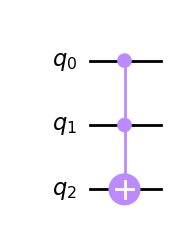

In [15]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager


circ = QuantumCircuit(3)
circ.ccx(0, 1, 2)
circ.draw(output='mpl', style='clifford')

/home/kaelyn/projects/Notes/qiskit-documentation/.venv/lib64/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


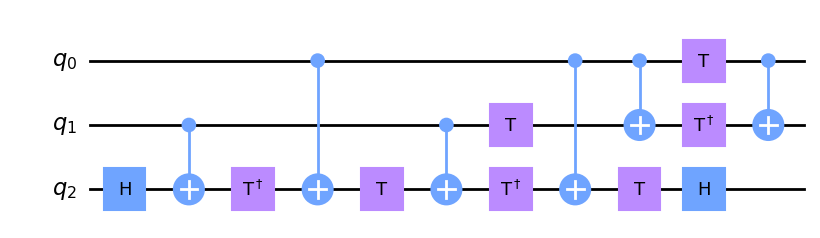

In [16]:
from qiskit.transpiler.passes import Unroll3qOrMore
pass_ = Unroll3qOrMore()
pm = PassManager(pass_)
new_circ = pm.run(circ)
new_circ.draw(output='mpl', style='clifford')

# Add in another pass as example to decompose to backend basis gates


`PassManagers` can also include control flow instructions to programatically execute different passes.  Once instantiated, new passes can be appended by the `PassManager.append()` method and can include a dictionary of flow controller plugins such as the [`DoWhileContoller`](../api/qiskit/qiskit.transpiler.DoWhileController.md) or [`ConditionalController`](../api/qiskit/qiskit.transpiler.ConditionalController.md).  (*this need more explanation*)

## Building & Using Custom Plugins

In this section we'll discuss installing and utilizing custom plugins, as well as writing your own from a `PassManager` object....

Look to the page on writing [transpiler plugins](https://qiskit.org/documentation/apidoc/transpiler_plugins.html#plugin-api)